In [1]:
import numpy as np
import pygad
import tree_representation
import csv
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Target:   -4*x**5 + 3*x**4 + -4*x**2 + -2*x + 5
Best solution + - * - 10.00 7.00 - x ^ x 5.00 ^ x 5.00 x
Best fitness -1.0609174783244865e+18


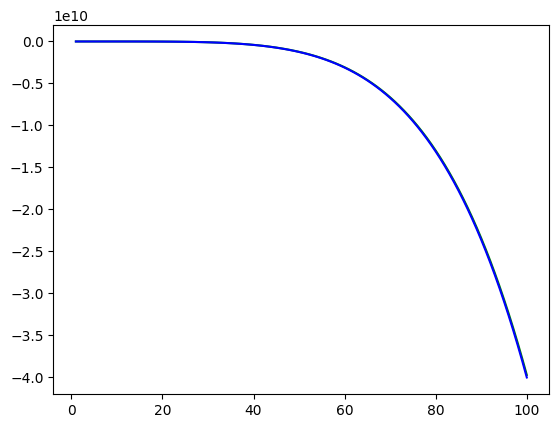

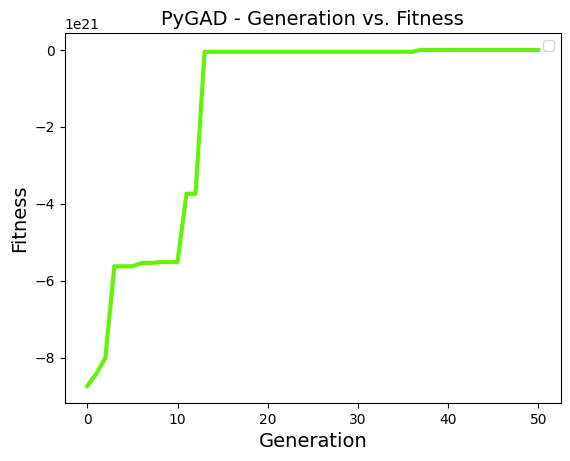

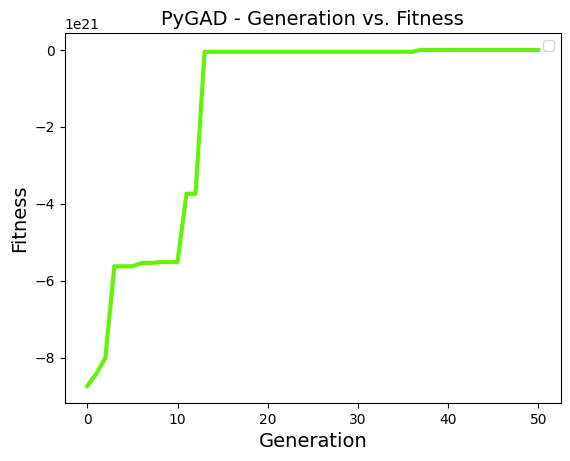

In [6]:
equation_index = 99

with open("dataset.csv") as file:
    reader = csv.reader(file)

    d = 0
    for row in reader:
        target = row[0]
        xs = np.fromstring(row[1][1:-1], sep=", ")
        ys = np.fromstring(row[2][1:-1], sep=", ")
        if d == equation_index:
           break
        d += 1

def fitness_func(ga_instance, solution, solution_idx):
  tree = tree_representation.fromIntArray(solution)
  fit = tree_representation.fitness(tree, xs, ys)
  return fit

def crossover_func(parents, offspring_size, ga_instance):
  offspring = []
  t1, t2 = tree_representation.fromIntArray(parents[0]), tree_representation.fromIntArray(parents[1])
  
  while len(offspring) != offspring_size[0]:
    child, _ = tree_representation.crossover_tree(t1, t2)

    try:
      offspring.append(tree_representation.toIntArray(child))
    except IndexError:
      print("Not crossovering")
    
  return np.array(offspring)

def mutation_func(offspring, ga_instance):
  new_offspring = []

  for t_numerical in offspring:
    t = tree_representation.fromIntArray(t_numerical)
    
    if (np.random.rand() < ga_instance.mutation_probability):
      t = tree_representation.mutate_tree(t)
    new_offspring.append(tree_representation.toIntArray(t))

  return np.array(new_offspring)


initial_population = [tree_representation.toIntArray(tree_representation.generate_random_tree()) for _ in range(5000)]

ga_instance = pygad.GA(num_generations=10,
                       num_parents_mating=2,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       keep_elitism=10,
                       crossover_type=crossover_func,
                       mutation_type=mutation_func,
                       gene_type=np.int8,
                       mutation_probability=1,
                       )

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Target: ", target)
print("Best solution", tree_representation.fromIntArray(solution))
print("Best fitness", solution_fitness)


plt.plot(xs, ys, color='green')
plt.plot(xs, [tree_representation.fromIntArray(solution).evaluate(x) for x in xs], color='blue')
# print(xs)
# print(tree_representation.fromIntArray(solution).evaluate(xs))
ga_instance.plot_fitness()